# Lab 1

Due:

October 13th

Grading:

Report 80 Percent, Code 20 Percent

## Part 0: Python [0 Points]

In this lab you will be using python for your experiments. We encourage you to develop modular code for your answers, and to avoid code repitition. To get you started, complete the following function to calculate the hellinger distance between two distributions. This part is not graded but many of your functions below will require the you to do the same calculation. It is a good idea to have such a function handy.

In [ ]:
def compute_hdist(dist1:list[int], dist2:list[int])->float:
    # TODO
    return

## Part 1: Noisy Circuits [40 Points]

### Preparing the Greenberger–Horne–Zeilinger State [20 Points]

In quantum computing, the GHZ (Greenberger-Horne-Zeilinger) state is a highly entangled quantum state involving multiple qubits (quantum bits). It is a specific type of multipartite entangled state that demonstrates some of the most intriguing and non-classical properties of quantum mechanics.

The GHZ state can be described as follows: When you have a GHZ state involving n qubits, it is a quantum superposition of all qubits being in the state |0⟩ or all qubits being in the state |1⟩. Mathematically, a 3-qubit GHZ state can be written as:

$|GHZ⟩ = (|000⟩ + |111⟩) / √2$

In this excercise you will develop a parameterized circuit to prepare the GHZ state on a quantum computer. Then you will use your circuit to experiment with the effects of noise on the GHZ state and analyze how the measured state differs from the ideal case.

#### Example:
Below  is the code to generate a 3-qubit GHZ state. Analyze the code and understand how it works. Refer to class notes as needed.

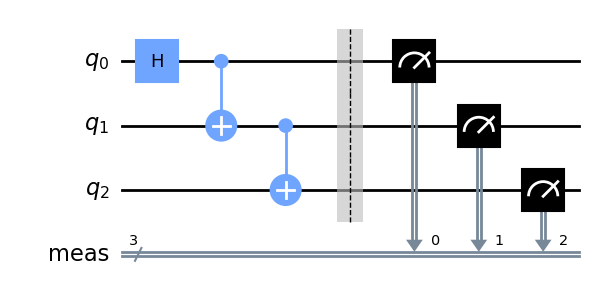

In [1]:
# Import Necessary Libraries
from qiskit import QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from math import pi
from matplotlib import pyplot as plt
from qiskit.providers.fake_provider import FakeAlmadenV2,FakeAthensV2, FakeCambridgeV2, FakeWashingtonV2
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_circuit_layout
from qiskit.providers.fake_provider import FakeVigo
import numpy as np
from qiskit import QuantumCircuit, transpile, assemble, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.tools.visualization import plot_histogram
from qiskit.providers.fake_provider import FakeWashingtonV2,FakeAlmadenV2,FakeAthensV2, FakeCambridgeV2
# Define the number of qubits in the GHZ state
num_qubits = 3

# Create a quantum circuit with the specified number of qubits
ghz_circuit = QuantumCircuit(num_qubits)

# Apply a Hadamard gate to the first qubit
ghz_circuit.h(0)

# Apply a series of CNOT gates to create entanglement
ghz_circuit.cx(0, 1)
ghz_circuit.cx(1, 2)

# Measure all qubits
ghz_circuit.measure_all()

#draw your circuit
ghz_circuit.draw('mpl')



After creating a circuit your next step is to simulate it. There are multiple ways to simulate a circuit. The biggest distinction, however, is between ideal simulations and noisy simulations. Ideal simulations show you what the output of the circuit is if we had a perfect quantum computer. It is identical to carrying out applying the operator represented by the circuit to the initial state and observing the output. Noisy simulation simulate the circuit on some backend specifications, and in the process transpile the circuit to the given architecture. The result of the simulation aims includes noise and should give you an idea of what the result of running your code on a real machine should be. 

First we run an ideal simulation:

/Users/alitaha/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


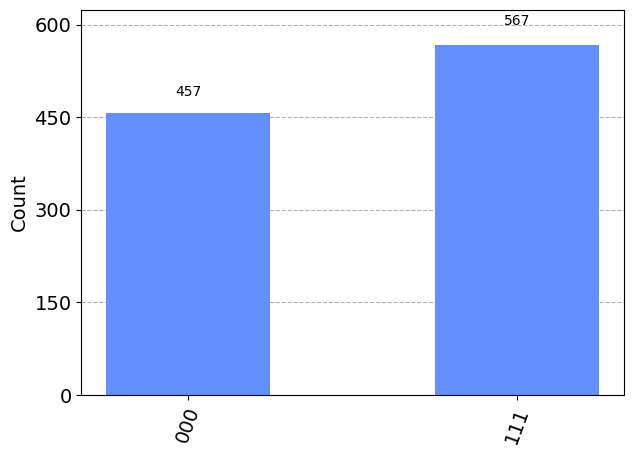

In [2]:
# Use the Aer simulator to execute the circuit
ideal_simulator = Aer.get_backend('statevector_simulator')
job = execute(ghz_circuit, ideal_simulator, shots=1024)

# Get the results and plot the histogram
ideal_result = job.result()
counts = ideal_result.get_counts()
plot_histogram(counts)

Now to run a noisy simulation we must take more steps:

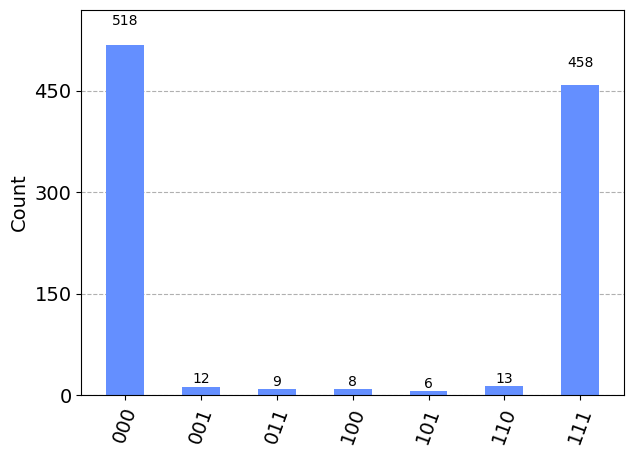

In [3]:
FakeWashingtonV2_backend = FakeWashingtonV2()
FakeWashingtonV2_simulator = AerSimulator.from_backend(FakeWashingtonV2_backend)
#Note that in the following line we specify the number of shots, this was not necessary in the ideal simulation
job = execute(ghz_circuit, FakeWashingtonV2_simulator, shots=1024)

# Get the results and plot the histogram
noisy_result = job.result()
counts = noisy_result.get_counts()
plot_histogram(counts)

#### Question 1 [10 Points]:
For this first question you have to create code to produce the GHZ State and measure how the produced distribution matches or differs from the expected outcome. Your measurement will be in the form of a success metric, such as the probability of success of your circuit. Your task is to implement the functions given below and then  select one of the metrics given in class. Note that for evaluation you will need to simulate with both a noisy simulator and an ideal one.

In [ ]:
#Complete the following function to create a circuit that prepares a GHZ state
def make_ghz(num_qubits: int)-> QuantumCircuit:
    # TODO
    return

#Complete the following function to calculate a measure of how the produced distribution differs from the calculated distribution (Note that for evaluation)
def evaluate_ghz(circuit: QuantumCircuit, backend: str)-> float:
    # TODO
    return


#### Question 2 [10 Points]:
For this question you  will use the functions you implemented to create a graph. On the Y axis you will have the metric of success you selected in the last question. On the X axis you will have the Quantum Volume. Your task is to find different backends with different quantum volumes and then produce use the functions you created above to make a plot of the metric against Quantum Volume. Furthermore you are required to do this three time each time with a different number of qubits. Use matplotlib to create your plots. Furthermore you are required to do this three time each time with a different number of qubits. Use matplotlib to create your plots.

Use the following backends:
```
Machine         QV
FakeLimaV2    :  8
FakeQuitoV2   : 16
FakeRomeV2    : 32
FakeDublinV2  : 64
FakeKolkataV2 :128
``````
Import them as necesssary. Look at the code above to see how to do that.

In [ ]:
def make_plots_ghz(Num_qubits: list[int]) -> None:
    # TODO

### Bernstein–Vazirani algorithm [20 Points]

The Bernstein-Vazirani algorithm serves as a great demonstration of how quantum algorithms can provide an exponential speedup over quantum algorithm. In this assignement you will further analyze how the performance of the circuit change with noise and the secret used.

#### Question 1
Using class notes as needed and the qiskit demo from class, create the following functions to create a Bernstein-Vazirani Circuit for N Qubits and to evaluat the performance of your circuit. As aforementioned, you will do the evaluation using a metric of success such as the probability of success. Note that there are other metrics of success that may be better

#### Question 1 [10 Points]:
For this first question you have to create code to produce the GHZ State and measure how the produced distribution matches or differs from the expected outcome. Your measurement will be in the form of a success metric, such as the probability of success of your circuit. Your task is to implement the functions given below and then  select one of the metrics given in class, 

In [ ]:
#Complete the following function to create a circuit that prepares a bv circuit
def make_bv(num_qubits: int, oracle:str)-> QuantumCircuit:
    # TODO
    return

#Complete the following function to calculate a measure of how the produced distribution differs from the ideal distribution.
#The ideal distribution can be found by running the circuit with the backend 'statevector_simulator'
def evaluate_bv(circuit: QuantumCircuit, backend: str)-> float:
    # TODO
    return


#### Question 2 [10 Points]:
For this question you  will use the functions you implemented to create a graph. On the Y axis you will have the metric of success you selected in the last question. On the X axis you will have the Quantum Volume. Your task is to experiment with different backends with different quantum volumes and then use the functions you created above to make a plot of the metric against Quantum Volume. Furthermore you are required to do this three time each time with a different number of qubits. Use matplotlib to create your plots.

Use the following backends:
```
Machine         QV
FakeLimaV2    :  8
FakeQuitoV2   : 16
FakeRomeV2    : 32
FakeDublinV2  : 64
FakeKolkataV2 :128
``````
Import them as necesssary. Look at the code above to see how to do that.

In [ ]:
def make_plots_bv(Num_qubits: list[int]) -> None:
    # TODO


#### Report:
In your report describe the metric of success that you used. Describe alternative metrics of success that you could have selected. In your analysis make sure to explain your choices and the tradeofss between metrics. Furthermore summarize your results, explain how they met or did not meet your expectations and why your expectations were what they were. Explain how the performance of the circuit scales with the circuit size and with quantum volume. Implicit in the evaluation is the number of shots used during your simulation, explain why you used the number of shots and how that affects the evaluation method.

## Part 2: Grover's Amplitude Amplification [30 Points]


Grover's algorithm, developed by Lov Grover in 1996, is a groundbreaking quantum computing algorithm with significant implications for the field of computer science and cryptography. Its primary significance lies in its ability to perform unstructured database searches exponentially faster than classical algorithms. Grover's algorithm offers a quadratic speedup over classical search algorithms, which is particularly relevant for tasks like searching unsorted databases or solving certain optimization problems efficiently. This quantum algorithm has the potential to revolutionize various fields, including cryptography, where it threatens classical encryption schemes by drastically reducing the security margin. As quantum computing technology continues to advance, Grover's algorithm represents a critical milestone in harnessing the power of quantum computation for practical applications.The problem that Grover's algorithm aims to solve is as follows: suppose we have a function $f:\{0,1, \ldots, N-1\} \rightarrow\{0,1\}$. This function can be interperted as a database: the domain represents indices to a database, and $f(x)=1$ if and only if the data that $x$ points to the object we are looking for. To solve a problem like this on a classical computer would usually require $O(N)$ time. However on a quantum system it only require $O(\sqrt{N})$ Queries.

The way grover's algorithm works as follows:

1. **Initialization**:
   - Start with a quantum computer that has access to a quantum oracle function, often denoted as *f(x)*, which marks the correct solution(s) in the database.
   - Prepare an equal superposition of all possible database entries. If there are *N* items in the database, this means initializing a quantum state that represents all *N* items with equal probability.

2. **Amplitude Amplification**:
   - Grover's algorithm iteratively applies two operations: the oracle and the Grover diffusion operator.

3. **Oracle Function (Quantum Black Box)**:
   - The oracle function *f(x)* flips the sign of the amplitude of the correct solution(s) in the superposition. It does this by applying a phase flip (changing the sign of the quantum state) to the correct solution(s) while leaving the other entries unchanged.
   - The oracle function is typically implemented as a quantum gate, and the number of queries needed to find the solution is roughly the square root of the total number of items, so it requires approximately √N queries.

4. **Grover Diffusion Operator**:
   - The Grover diffusion operator serves to amplify the amplitude of the correct solution(s) and reduce the amplitude of the incorrect ones.
   - It consists of the following steps:
     a. Apply a Hadamard transform to put the quantum state back into a roughly equal superposition.
     b. Apply an operation that reflects the quantum state about the average amplitude (inversion about the mean).
     c. Apply another Hadamard transform to revert the quantum state to a computational basis.

5. **Iteration**:
   - Steps 3 and 4 are repeated for a specific number of iterations, which is approximately π/4 times the square root of N. This number of iterations ensures that the amplitude of the correct solution(s) becomes significantly higher than the incorrect ones.

6. **Measurement**:
   - After a sufficient number of iterations, a measurement of the quantum state is performed.
   - The probability of measuring the correct solution(s) will be much higher than that of measuring an incorrect one, making it highly likely to find the solution(s).

In summary, Grover's algorithm utilizes quantum parallelism and constructive interference to systematically amplify the probability of finding the correct solution in an unsorted database. While it provides a quadratic speedup compared to classical brute-force search algorithms, it is essential to note that it is not exponentially faster like some other quantum algorithms, such as Shor's algorithm for factoring large numbers. Nonetheless, Grover's algorithm has significant practical applications in various fields, including cryptography and optimization.

#### Here is an implementation of the algorithm:

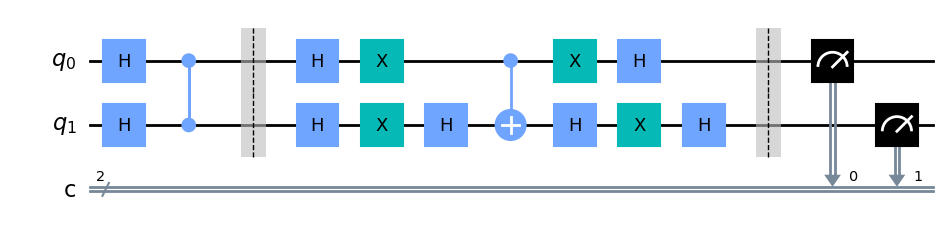

In [4]:
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

# Number of qubits (for a 3-qubit problem)
n = 2

# Number of Grover iterations for quadratic speedup (usually pi/4 * sqrt(2^n))
grover_iterations = 1

# Create a quantum circuit with n qubits and n classical bits
qc = QuantumCircuit(n, n)

# Initialization: Apply Hadamard gates to all qubits
qc.h(range(n))

# Oracle: Mark the target states (e.g., |010>, |110>)
qc.cz(0,1)
qc.barrier()


def diffuser(qc, nqubits):
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
# Grover's Algorithm: Perform Grover iterations
diffuser(qc,2)
qc.barrier()

# Measurement
qc.measure(range(n), range(n))
qc.draw('mpl')

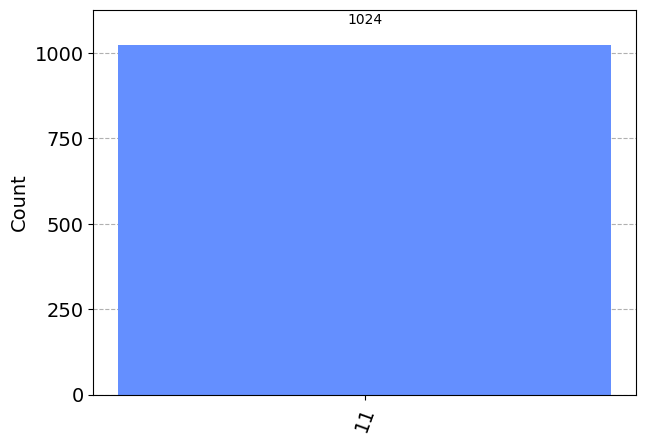

In [5]:
# Use the Aer simulator to execute the circuit
simulator = Aer.get_backend('statevector_simulator')
job = execute(qc, simulator, shots=1024)

# Get the results and plot the histogram
result = job.result()
counts = result.get_counts()
plot_histogram(counts)

#### Question 1 [15 Points]
For this first part your task is to create a circuit for grover's algorithm with 5 qubits. Create the oracle and encode a bitstring string of your choice, it must have only one 1. Copy the code from above and edit it as needed. Analyze how the performance of your circuit changes changes as the diffuser operation and the oracle operation change. If you used any sources in your report please cite them.

In [ ]:
# Write a function to create a circuit for grover's algorithm with n iterations i.e. n applications of the oracle and the diffuser operations for this
# task you are also requried to take in a string that represents the oracle. For now use a 
def make_grover(r_iterations: int) -> QuantumCircuit:
    # TODO
    return 

# Write a function to evaluate your circuit using a metric of success of your choice ()
def evaluate_grover(circuit: QuantumCircuit, backend: str) -> float:
    # TODO
    return

#### Question 2 [15 Points]

For this second Question your task is to use the code that you developed to anayze the performance of your circuit. The X axis in your plot should be the number of iterations. the Y axis should be the success metric you have selected.  Produce a total of two plots one for the experiment on an ideal simulation. Another for the experiment on a noisy backend of your choice.

In [12]:
def make_plots_grover(Num_qubits: list[int]) -> None:
    # TODO
    return

#### Report
In your report include a section on grover's algorithm. Explain how you encoded the oracle string in your circuit.  Analyze how the number of grover iterations affects your choosen metric, why you have choosen that metric and how would other metrics be better or worse. Does the performance increase as you increase the depth of the circuit? How does this vary between ideal and noisy simulation?

## Part 3: Routing

Routing in quantum compilation is essential for optimizing the translation of high-level quantum algorithms to quantum hardware. It helps conserve resources, minimize errors, improve execution speed, enhance quantum volume, ensure hardware compatibility, enable scalability, and support error mitigation, all of which are vital for the practical implementation of quantum computations. In class we discovered various routing algorithms and how the architecture can act as a limiting factor on the perfromance of the routing algorithm. In this question we explore various backends and analyze how they they affect routing and how the routing affects the error rates.

#### Coupling Map

Routing is highly machine dependent ans so to understand how to route, and how to find an optimal routing you must understand the machine architecture.
The code below generates the coupling map for an architecture. Note that the coupling map is fundamentally just a graph structure and that is what is depicted below. The graph layout algorithm is stochastic so it varies everytime you run the code

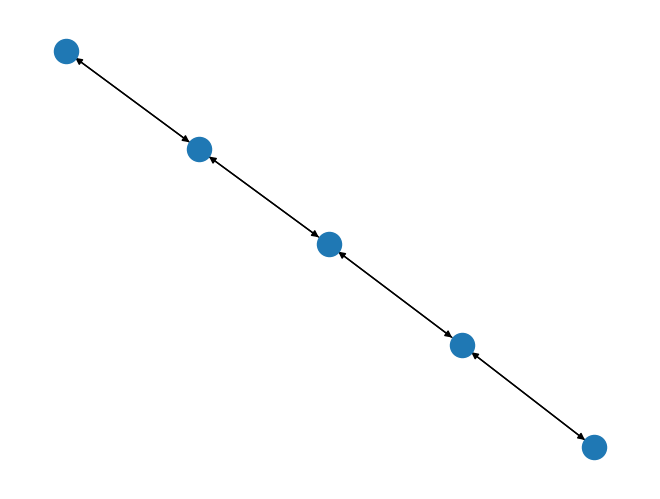

In [6]:
from qiskit import QuantumCircuit, execute, IBMQ
from qiskit.visualization import plot_error_map
import rustworkx as rx

device_backend = FakeAthensV2()
rx.visualization.mpl_draw(device_backend.coupling_map.graph)

#### Error Maps

An important consideration when doing routing is noise and error rates across gates. The code below generates the error map for the Athens Machine on IBM's System. This provides more information than the basic coupling map.

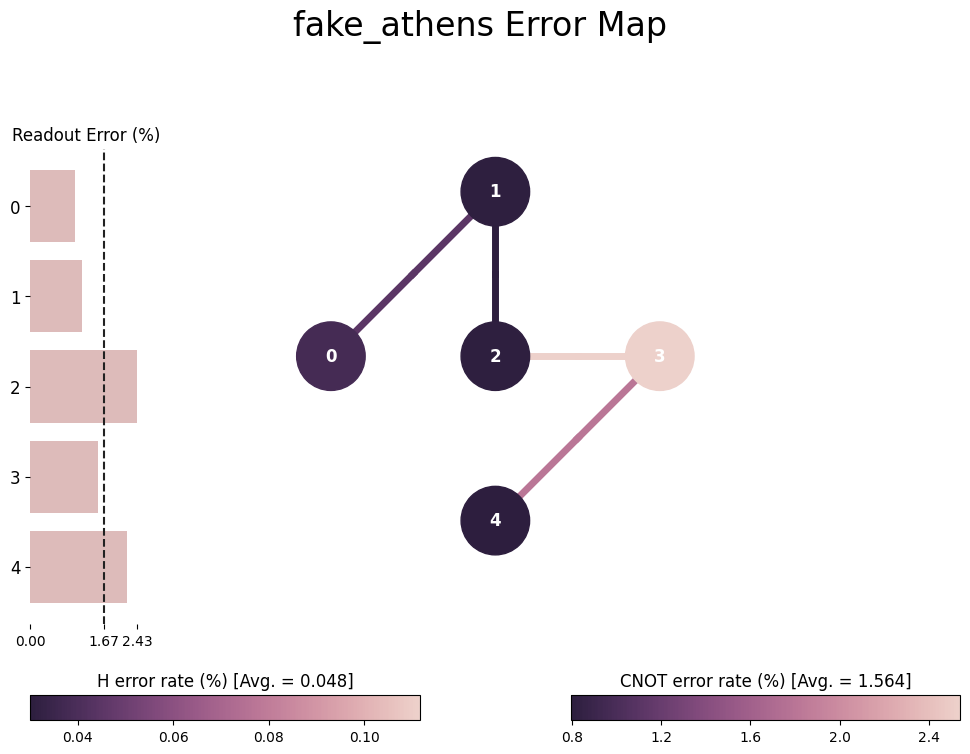

In [7]:
plot_error_map(device_backend)

#### Question 1 Routing and Swaps [15 Points]
For this question you will use the FakeAlmadenV2,FakeAthensV2, FakeCambridgeV2 architecture to analyze the impact of architecture on the performance of the following circuit. Take a look at the circuit below

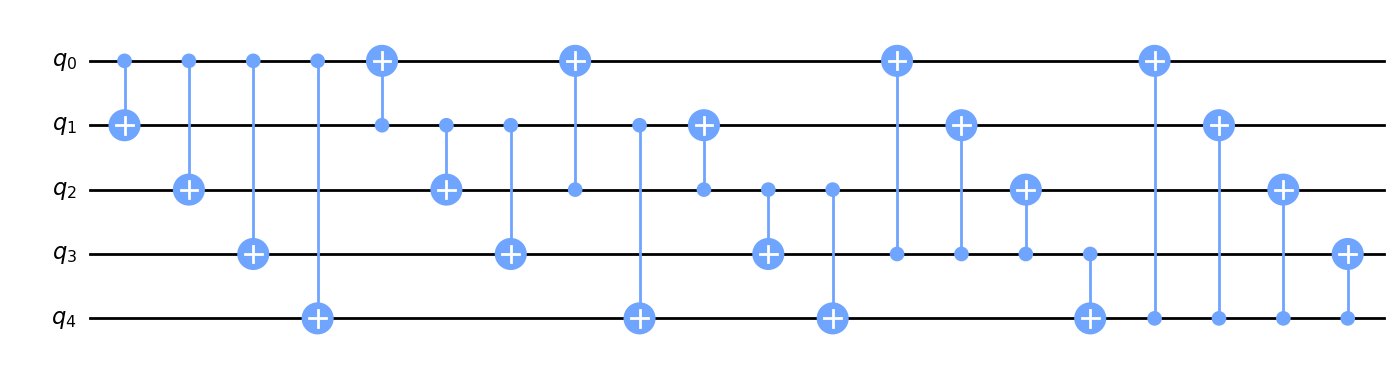

In [8]:
def generate_complex(n):
    qc_complex = QuantumCircuit(n)
    for i in range(5):
        for j in range(5):
            if i!=j:
                qc_complex.cx(i,j)
    return qc_complex
generate_complex(5).draw('mpl')

The circuit has many CNOT operations and thus its performance is highly dependent on architecture. A good metric too look at to analyze the impact of the architecture is the number of swaps used in the final transpiled circuit. You can find it as follows:

In [26]:
backend_simulator = AerSimulator.from_backend(device_backend)
transpiled_circuit = transpile(generate_complex(5), backend_simulator)
# Count the number of 'cx' gates (swaps)
print(transpiled_circuit.count_ops()['cx'])


60


For this question transpile circuits for the three architectures given above for 3,4,5,7,10,15 qubits as possible (one of the machines only has 5 qubits). Analyze how the number of swaps needed varies with the machine selected and the size of the circuit by making a plot of the data. If there are peaks or jumps in the number of swaps as the scaling experiment happens explain that using the error map of the graph.

#### Report
Summarize your findings from the part above. Analyze the differences between the architectures and how that affects the number of swaps necessary. Furthermore, discuss how you the circuit above maybe be rewritten to improve performance and reduce swaps.

#### Question 2

For this question you will explore the advantages of noise adaptive routing. Examine the following circuit:

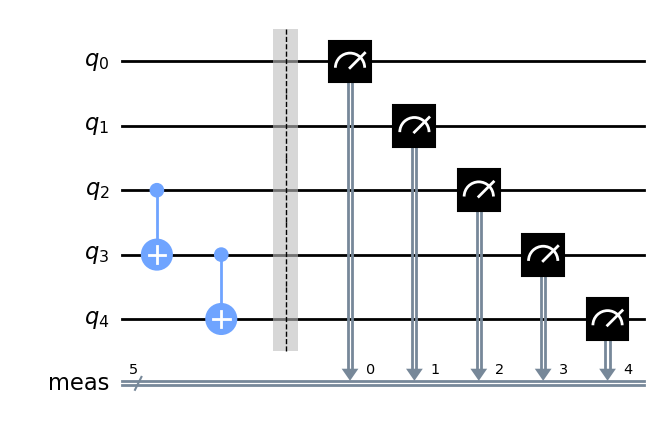

In [10]:
qc = QuantumCircuit(5)
qc.cx(2,3)
qc.cx(3,4)
qc.measure_all()
qc.draw('mpl')

If we transpile with optimization_level 0 we get the following mapping

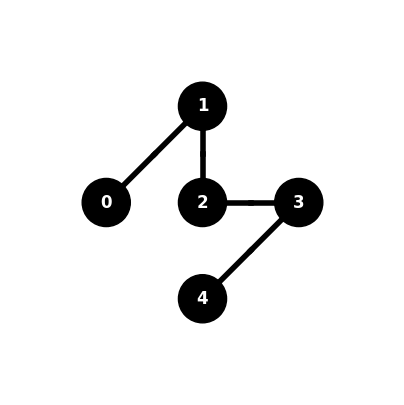

In [11]:

backend = FakeAthensV2()
new_circ_lv0 = transpile(qc, backend=backend, optimization_level=0)
plot_circuit_layout(new_circ_lv0, backend)

If we transpile with optimization level 3 we get the following mapping:

/Users/alitaha/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: divide by zero encountered in det
  r = _umath_linalg.det(a, signature=signature)
/Users/alitaha/Library/Python/3.9/lib/python/site-packages/numpy/linalg/linalg.py:2154: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)


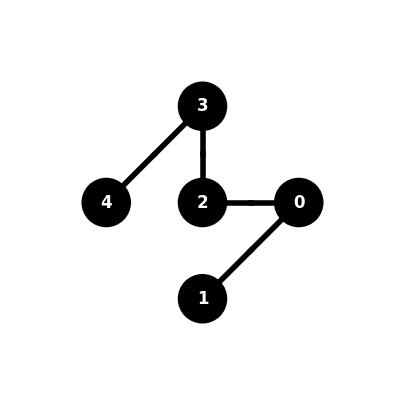

In [12]:

new_circ_lv0 = transpile(qc, backend=backend, optimization_level=3)
plot_circuit_layout(new_circ_lv0, backend)

Analyze how the mappings differ and in your report explain why there is a difference. Furthermore below select one of the circuits you constructed above: grovers, GHZ, BV, analyze how its routed on the three architectures FakeAlmadenV2,FakeAthensV2, FakeCambridgeV2. Analyze how the routing changes with different optimization levels. Refer to the Qiskit documentation for more info if needed. Only consider the case of 5 qubits.

#### Report

In your report summarize your findings and explain how in your experiments noise adaptive routing impacted the mapping of your qubit.